# Analyzing SAT Performance of Public Schools in New York

### Data Source

New York City provides alot of open data on the public education system. We will be using the most [recent high school quality report (2014-2015)](https://data.cityofnewyork.us/download/vrfr-9k4d/application%2Fvnd.ms-excel) which evaluates students performance and achievement based on SAT scores. The data, provided by Department of Education, contains a **district borough number (DBN)** column which classifies each district a school is located. It also includes over 30+ parameters such as economic need index, percentage in temporary housing, and safety of students. The dataset is in the from of an excel sheet with 6 tabs, which has been converted into a CSV and uploaded to github for easy access. 


### Libraries and API
There are 493 public schools in NYC. The dataset offers scores of 400 schools. Those with less than 10 students that take the SAT do no report scores. First, we chose the 2 excel tabs that provide the SAT scores and a file with variables that affect school envrionment.
Since the DBN is only used in New York, we used googlegeocoder API to match the DBN with their respective zip codes. **The geocode returns a full address of each DBN, which then we must scrape and split to only retain the borough and zipcode** After matching up the zipcode, we then further explore details about each district by merging the information with the U.S. Census API. 

Of the packages discussed in class, we will be using:
* `pandas` to create dataframes
* `numpy`
* `Census` API to merge income data with zipcodes
* `matplotlib` to graph analysis

New packages used are:
* `googlegeocoder` to align data with zipcodes 
* `geopandas` to create maps from a shapefile


In [3]:
# import packages 
import sys
import pandas as pd                   
import matplotlib.pyplot as plt      
import datetime as dt                  
import numpy as np                    
import seaborn as sns
import statistics
from scipy import stats

from googlegeocoder import GoogleGeocoder #to match up DBN with zipcode

from census import Census            
from us import states   

import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import pysal as ps
%matplotlib inline      

In [4]:
api_key = "670c60e67279b6125d24adb8a5ab50638d3f1ac7"
c = Census(api_key)

In [5]:
clean_file = "https://raw.githubusercontent.com/linnaha/NYCdata/master/sat_zip_clean.csv"
satdata = pd.read_csv(clean_file, encoding='latin-1') #seperate file with just zipcodes and sat scores

In [7]:
satdata = satdata.rename(columns={'School Name':'name',"Average Score SAT Math":"avg_math","Average Score SAT Critical Reading":"avg_read","Average Score SAT Writing":"avg_write","Average SAT Score for Three sections":"avg_sat"})

### What are some causes for the disparity between scores?


Let's first take a look at income. We will use the U.S. Census API that we called before and merge it with our sat dataframe.

In [8]:
satdf_top = satdata[["name","avg_math","avg_read","avg_write","avg_sat","borough","zip"]].copy()
satdf_top.sort_values(by="avg_sat",ascending=False, inplace=True)

In [9]:
code = ("B19013_001E") 
#code for median houshold income
    
zip_2015 = pd.DataFrame(c.acs5.get(code, 
                                         {'for': "zip code tabulation area:*"}, year=2015))
#the * will get all the zipcodes. Then we will merge so that only the zipcodes that are in  our dataset will appear.

In [10]:
zip_2015 = zip_2015.rename(columns={'zip code tabulation area':'zip', 
                                    'B19013_001E':'avg_income'})

In [11]:
zip_2015['zip'] = zip_2015['zip'].astype(str).astype(int) 

In [12]:
income_satdf = pd.merge(satdf_top,zip_2015,   
                     how='left',      # will merge with only the data in the left, which is our satdf_top
                 on='zip',       
                 indicator=True) 
income_satdf.head()

,name,avg_math,avg_read,avg_write,avg_sat,borough,zip,avg_income,_merge
0,Stuyvesant High School,754,697,693,2144,New_York,10282,250001.0,both
1,Bronx High School of Science,714,660,667,2041,Bronx,10468,34784.0,both
2,Staten Island Technical High School,711,660,670,2041,Staten_Island,10306,79686.0,both
3,High School of American Studies at Lehman College,669,672,672,2013,Bronx,10468,34784.0,both
4,Townsend Harris High School,680,640,661,1981,Queens,11367,56557.0,both


## Mapping SAT Scores

Using geopandas, we can create a map of the New York City area and plot our dataset onto it. First, we had to get a [shape file](https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data) which contains the data of the district and zip code boundaries. Once it is downloaded, we can source it into the notebook.

In [14]:
path = "/Users/linnaha/Downloads/"

zip_file = path + "ZIP_CODE_040114" #this is for mac users

In [15]:
test = gpd.read_file(zip_file)
zipmap = pd.DataFrame(test)

In [16]:
test = test.rename(columns={'ZIPCODE':'zip'})
test['zip'] = test['zip'].astype(str).astype(int) #must change dtype from object to integer
test["zip"].dtypes #now that the zip is an integer, we can merge 

dtype('int64')

In [17]:
zipmap  = test.merge(income_satdf, on='zip', how = "outer")
zipmap.head()

,zip,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,SHAPE_LEN,geometry,name,avg_math,avg_read,avg_write,avg_sat,borough,avg_income,_merge
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",Pathways in Technology Early College High Scho...,446.0,442.0,410.0,1298.0,Brooklyn,34701.0,both
2,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",KIPP AMP Charter School,452.0,411.0,418.0,1281.0,Brooklyn,34701.0,both
3,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",Academy for Health Careers,406.0,405.0,396.0,1207.0,Brooklyn,34701.0,both
4,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",Boys and Girls High School,399.0,392.0,394.0,1185.0,Brooklyn,34701.0,both


/Users/linnaha/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
/Users/linnaha/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


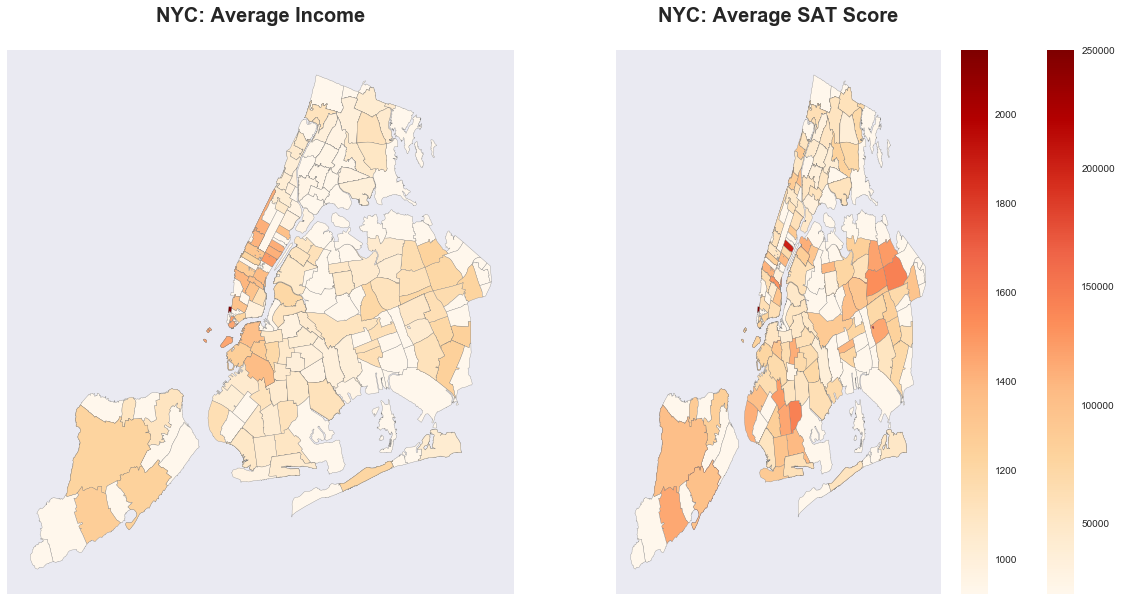

In [18]:
fig, ax = plt.subplots(1,2,figsize = (20,10))

# First create the map for NYC
######################################################################################
# Then lets create the map for income

zipmap.plot(ax = ax[0], edgecolor='tab:grey', k =14,
             column='avg_income',
            cmap='OrRd', alpha = 1.0, 
            #scheme="Quantiles",
            legend = True )

plt.legend(loc = 2)
######################################################################################    

ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[0].set_title("NYC: Average Income\n", fontsize=20, fontweight="bold")

######################################################################################
######################################################################################
# Then lets create the map for SAT scores

zipmap.plot(ax = ax[1], edgecolor='tab:grey', 
                column='avg_sat', 
            #scheme = "Quantiles"
             cmap='OrRd', 
            alpha = 1.0, legend=True, k=9,)

######################################################################################
  
    
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

ax[1].set_title("NYC: Average SAT Score\n",fontsize=20, fontweight="bold")

ax[1].legend(loc=2)